In [72]:
from random import random
import numpy as np
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
import heapq
import seaborn as sns
import pandas as pd
import itertools
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep", n_colors=13)
np.random.seed(44)

In [7]:
def sim_clock(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_clock = [tg.sim_clock(int(_c), trace, raw=True, K=cnt) for _c in c]
    return c, hr_clock

def sim_ran_clock(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_ran_clock = [tg.sim_ran_clock(int(_c), trace, raw=False, K=cnt) for _c in c]
    return c, hr_ran_clock

def sim_fifo_m(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_fifo_m = [tg.sim_fifo_m([int(s)//2, int(s) - int(s)//2], trace, raw=False) for s in c] 
    return c, hr_fifo_m

def sim_rand_m(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_rand_m = [tg.sim_rand_m([int(s)//2, int(s) - int(s)//2], trace, raw=False) for s in c] 
    return c, hr_rand_m

def sim_sieve(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_sieve = [tg.sim_sieve(int(_c), trace, raw=False, K=cnt) for _c in c]
    return c, hr_sieve

def sim_ran_sieve(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M+1, K)
    hr_ran_sieve = [tg.sim_ran_sieve(int(_c), trace, raw=False, K=cnt) for _c in c]
    return c, hr_ran_sieve

def sim_lru(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_lru = [tg.sim_lru(int(_c), trace, raw=False) for _c in c]
    return c, hr_lru

def sim_fifo(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(2, M, K)
    hr_fifo = [tg.sim_fifo(int(_c), trace, raw=False) for _c in c]
    return c, hr_fifo

def gen_from_zipf(M, n, a):
    p = 1.0 / np.power(np.arange(1, M + 1), a)
    p = p / p.sum()
    return p, np.random.choice(M, size=n, p=p)

In [3]:
def gen_ph(m, theta, length):
    p = 1.0 / np.power(np.arange(1, m + 1), theta)
    p = p / p.sum()
    cp = np.cumsum(p)
    t = p.copy()
    phases = np.searchsorted(cp, np.random.random(m), side="right")
    next_times = np.random.exponential(1.0 / t[phases])
    heap = [(next_times[i], i) for i in range(m)]
    heapq.heapify(heap) 
    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = np.searchsorted(cp, np.random.random(), side="right")
        next_time = ctime + np.random.exponential(1.0 / t[phases[item]])
        heapq.heappush(heap, (next_time, item))
    return trace

def gen_ph_2class(n, theta, length, mu_ratio=10.0):
    p = 1.0 / np.power(np.arange(1, n + 1), theta)
    p /= p.sum()
    alpha0 = 0.5
    alpha = np.array([0.5, 0.5], dtype=float)
    mu2 = (1.0 / mu_ratio + 1.0) / 2.0
    mu1 = mu_ratio * mu2
    T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=float)
    t = -T.sum(axis=1)
    B = T + t[:, None] * alpha[None, :]
    scale = np.max(-np.diag(B))
    P = B / scale + np.eye(2)
    a, b = P[0, 1], P[1, 0]
    beta = np.array([0.5, 0.5], dtype=float) if a + b == 0 else np.array([b / (a + b), a / (a + b)], dtype=float)
    arate = beta.dot(t)
    t /= arate
    phases = (np.random.random(n) >= alpha0).astype(np.int8)
    rates = t[phases] * p
    next_times = np.random.exponential(1.0 / rates)
    heap = [(next_times[i], i) for i in range(n)]
    heapq.heapify(heap)

    trace = np.empty(length, dtype=np.int32)
    for idx in range(length):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = 0 if np.random.random() < alpha0 else 1
        rate = t[phases[item]] * p[item]
        heapq.heappush(heap, (ctime + np.random.exponential(1.0 / rate), item))
    return trace

In [4]:
# lmb, irm2 = gen_from_zipf(120, 10000000, 0.8)
# he2 = gen_ph(120, 0.8, 10000000)
# ph2 = gen_ph_2class(120, 0.8, 10000000, mu_ratio=10.0)
irm_08 = np.loadtxt('zipf_120_08_trace.txt', dtype=np.int32)
# he2 = np.loadtxt('he_120_08_trace.txt', dtype=np.int32)
ph_08 = np.loadtxt('ph_120_08_trace.txt', dtype=np.int32)

irm_11 = np.loadtxt('zipf_120_11_trace.txt', dtype=np.int32)
ph_11 = np.loadtxt('ph_120_11_trace.txt', dtype=np.int32)

In [ ]:
# # sieve
# i08_cs1, i08_hrs1 = sim_sieve(irm_08, cnt=1)
# p08_cs1, p08_hrs1 = sim_sieve(ph_08, cnt=1)
# i11_cs1, i11_hrs1 = sim_sieve(irm_11, cnt=1)
# p11_cs1, p11_hrs1 = sim_sieve(ph_11, cnt=1)
# i08_cs16, i08_hrs16 = sim_sieve(irm_08, cnt=16)
# p08_cs16, p08_hrs16 = sim_sieve(ph_08, cnt=16)
# i11_cs16, i11_hrs16 = sim_sieve(irm_11, cnt=16)
# p11_cs16, p11_hrs16 = sim_sieve(ph_11, cnt=16)
# # ran-sieve
# i08_crs1, i08_hrcrs1 = sim_ran_sieve(irm_08, cnt=1)
# p08_crs1, p08_hrcrs1 = sim_ran_sieve(ph_08, cnt=1)
# i11_crs1, i11_hrcrs1 = sim_ran_sieve(irm_11, cnt=1)
# p11_crs1, p11_hrcrs1 = sim_ran_sieve(ph_11, cnt=1)
# i08_crs16, i08_hrcrs16 = sim_ran_sieve(irm_08, cnt=16)
# p08_crs16, p08_hrcrs16 = sim_ran_sieve(ph_08, cnt=16)
# i11_crs16, i11_hrcrs16 = sim_ran_sieve(irm_11, cnt=16)
# p11_crs16, p11_hrcrs16 = sim_ran_sieve(ph_11, cnt=16)
# # ran-clock
# i08_crc1, i08_hrcrc1 = sim_ran_clock(irm_08, cnt=1)
# p08_crc1, p08_hrcrc1 = sim_ran_clock(ph_08, cnt=1)
# i11_crc1, i11_hrcrc1 = sim_ran_clock(irm_11, cnt=1)
# p11_crc1, p11_hrcrc1 = sim_ran_clock(ph_11, cnt=1)
# i08_crc16, i08_hrcrc16 = sim_ran_clock(irm_08, cnt=16)
# p08_crc16, p08_hrcrc16 = sim_ran_clock(ph_08, cnt=16)
# i11_crc16, i11_hrcrc16 = sim_ran_clock(irm_11, cnt=16)
# p11_crc16, p11_hrcrc16 = sim_ran_clock(ph_11, cnt=16)
# # clock
# i08_ccc1, i08_hrccc1 = sim_clock(irm_08, cnt=1)
# p08_ccc1, p08_hrccc1 = sim_clock(ph_08, cnt=1)
# i11_ccc1, i11_hrccc1 = sim_clock(irm_11, cnt=1)
# p11_ccc1, p11_hrccc1 = sim_clock(ph_11, cnt=1)
# i08_ccc16, i08_hrccc16 = sim_clock(irm_08, cnt=16)
# p08_ccc16, p08_hrccc16 = sim_clock(ph_08, cnt=16)
# i11_ccc16, i11_hrccc16 = sim_clock(irm_11, cnt=16)
# p11_ccc16, p11_hrccc16 = sim_clock(ph_11, cnt=16)
# # fifo-m
# i08_cfm, i08_hrcfm = sim_fifo_m(irm_08)
# p08_cfm, p08_hrcfm = sim_fifo_m(ph_08)
# i11_cfm, i11_hrcfm = sim_fifo_m(irm_11)
# p11_cfm, p11_hrcfm = sim_fifo_m(ph_11)
# # rand-m
# i08crm, i08_hrcrm = sim_rand_m(irm_08)
# p08crm, p08_hrcrm = sim_rand_m(ph_08)
# i11crm, i11_hrcrm = sim_rand_m(irm_11)
# p11crm, p11_hrcrm = sim_rand_m(ph_11)
# # lru
# i08_clru, i08_hrclru = sim_lru(irm_08)
# p08_clru, p08_hrclru = sim_lru(ph_08)
# i11_clru, i11_hrclru = sim_lru(irm_11)
# p11_clru, p11_hrclru = sim_lru(ph_11)
# # fifo
# i08_cf, i08_hrcf = sim_fifo(irm_08)
# p08_cf, p08_hrcf = sim_fifo(ph_08)
# i11_cf, i11_hrcf = sim_fifo(irm_11)
# p11_cf, p11_hrcf = sim_fifo(ph_11)

In [ ]:
# np.savez_compressed('data/mrcs_irm_08.npz',
#     c_sieve=i08_cs1, hr_sieve=i08_hrs1,
#     c_sieve16=i08_cs16, hr_sieve16=i08_hrs16,
#     c_ran_sieve1 = i08_crs1, hr_ran_sieve1 = i08_hrcrs1,
#     c_ran_sieve16 = i08_crs16, hr_ran_sieve16 = i08_hrcrs16,
#     c_ran_clock1 =i08_crc1, hr_ran_clock1 = i08_hrcrc1,
#     c_ran_clock16=i08_crc16, hr_ran_clock16=i08_hrcrc16,
#     c_clock=i08_ccc1, hr_clock=i08_hrccc1,
#     c_clock16=i08_ccc16, hr_clock16=i08_hrccc16,
#     c_fifo_m=i08_cfm, hr_fifo_m=i08_hrcfm,
#     c_rand_m=i08crm, hr_rand_m=i08_hrcrm,
#     c_lru=i08_clru, hr_lru=i08_hrclru,
#     c_fifo=i08_cf, hr_fifo=i08_hrcf)
i08_cs1, i08_hrs1, i08_cs16, i08_hrs16, i08_crs1, i08_hrcrs1, i08_crs16, i08_hrcrs16, i08_crc1, i08_hrcrc1, i08_crc16, i08_hrcrc16, i08_ccc1, i08_hrccc1, i08_ccc16, i08_hrccc16, i08_cfm, i08_hrcfm, i08crm, i08_hrcrm, i08_clru, i08_hrclru, i08_cf, i08_hrcf = np.loadz('data/mrcs_irm_08.npz', allow_pickle=True).values()
# np.savez_compressed('data/mrcs_irm_11.npz',
#     c_sieve=i11_cs1, hr_sieve=i11_hrs1,
#     c_sieve16=i11_cs16, hr_sieve16=i11_hrs16,
#     c_ran_sieve1 = i11_crs1, hr_ran_sieve1 = i11_hrcrs1,
#     c_ran_sieve16 = i11_crs16, hr_ran_sieve16 = i11_hrcrs16,
#     c_ran_clock1 =i11_crc1, hr_ran_clock1 = i11_hrcrc1,
#     c_ran_clock16=i11_crc16, hr_ran_clock16=i11_hrcrc16,
#     c_clock=i11_ccc1, hr_clock=i11_hrccc1,
#     c_clock16=i11_ccc16, hr_clock16=i11_hrccc16,
#     c_fifo_m=i11_cfm, hr_fifo_m=i11_hrcfm,
#     c_rand_m=i11crm, hr_rand_m=i11_hrcrm,
#     c_lru=i11_clru, hr_lru=i11_hrclru,
#     c_fifo=i11_cf, hr_fifo=i11_hrcf)    
i11_cs1, i11_hrs1, i11_cs16, i11_hrs16, i11_crs1, i11_hrcrs1, i11_crs16, i11_hrcrs16, i11_crc1, i11_hrcrc1, i11_crc16, i11_hrcrc16, i11_ccc1, i11_hrccc1, i11_ccc16, i11_hrccc16, i11_cfm, i11_hrcfm, i11crm, i11_hrcrm, i11_clru, i11_hrclru, i11_cf, i11_hrcf = np.loadz('data/mrcs_irm_11.npz', allow_pickle=True).values()
# np.savez_compressed('data/mrcs_ph_08.npz',
#     c_sieve=p08_cs1, hr_sieve=p08_hrs1,
#     c_sieve16=p08_cs16, hr_sieve16=p08_hrs16,
#     c_ran_sieve1 = p08_crs1, hr_ran_sieve1 = p08_hrcrs1,
#     c_ran_sieve16 = p08_crs16, hr_ran_sieve16 = p08_hrcrs16,
#     c_ran_clock1=p08_crc1, hr_ran_clock1=p08_hrcrc1,
#     c_ran_clock16=p08_crc16, hr_ran_clock16=p08_hrcrc16,
#     c_clock=p08_ccc1, hr_clock=p08_hrccc1,
#     c_clock16=p08_ccc16, hr_clock16=p08_hrccc16,
#     c_fifo_m=p08_cfm, hr_fifo_m=p08_hrcfm,
#     c_rand_m=p08crm, hr_rand_m=p08_hrcrm,
#     c_lru=p08_clru, hr_lru=p08_hrclru,
#     c_fifo=p08_cf, hr_fifo=p08_hrcf)
p08_cs1, p08_hrs1, p08_cs16, p08_hrs16, p08_crs1, p08_hrcrs1, p08_crs16, p08_hrcrs16, p08_crc1, p08_hrcrc1, p08_crc16, p08_hrcrc16, p08_ccc1, p08_hrccc1, p08_ccc16, p08_hrccc16, p08_cfm, p08_hrcfm, p08crm, p08_hrcrm, p08_clru, p08_hrclru, p08_cf, p08_hrcf = np.loadz('data/mrcs_ph_08.npz', allow_pickle=True).values()
# np.savez_compressed('data/mrcs_ph_11.npz',
#     c_sieve=p11_cs1, hr_sieve=p11_hrs1,
#     c_sieve16=p11_cs16, hr_sieve16=p11_hrs16,
#     c_ran_sieve1 = p11_crs1, hr_ran_sieve1 = p11_hrcrs1,
#     c_ran_sieve16 = p11_crs16, hr_ran_sieve16 = p11_hrcrs16,
#     c_ran_clock1=p11_crc1, hr_ran_clock1=p11_hrcrc1,
#     c_ran_clock16=p11_crc16, hr_ran_clock16=p11_hrcrc16,
#     c_clock=p11_ccc1, hr_clock=p11_hrccc1,
#     c_clock16=p11_ccc16, hr_clock16=p11_hrccc16,
#     c_fifo_m=p11_cfm, hr_fifo_m=p11_hrcfm,
#     c_rand_m=p11crm, hr_rand_m=p11_hrcrm,
#     c_lru=p11_clru, hr_lru=p11_hrclru,
#     c_fifo=p11_cf, hr_fifo=p11_hrcf)  
p11_cs1, p11_hrs1, p11_cs16, p11_hrs16, p11_crs1, p11_hrcrs1, p11_crs16, p11_hrcrs16, p11_crc1, p11_hrcrc1, p11_crc16, p11_hrcrc16, p11_ccc1, p11_hrccc1, p11_ccc16, p11_hrccc16, p11_cfm, p11_hrcfm, p11crm, p11_hrcrm, p11_clru, p11_hrclru, p11_cf, p11_hrcf = np.loadz('data/mrcs_ph_11.npz', allow_pickle=True).values()

In [11]:
def p_vec(theta, n):
    ranks = np.arange(1, n + 1, dtype=float)
    p = 1.0 / np.power(ranks, theta)
    p /= p.sum()
    return np.cumsum(p)

def ub_dist(cache_sizes, hit_rates, p):
    cache_sizes = np.asarray(cache_sizes, dtype=int)
    ub = p[cache_sizes-1]
    dist = np.asarray(hit_rates) - ub
    return dist

In [12]:
p08 = p_vec(theta=0.8, n=120)
p11 = p_vec(theta=1.1, n=120)

In [98]:
base_styles = {
    'SIEVE': (palette[0], '^'),
    'Ran-SIEVE': (palette[1], 'D'),
    'Ran-CLOCK': (palette[2], 'o'),
    'CLOCK': (palette[3], 'o'),
    'FIFO(m)': (palette[4], 'P'),
    'RAND(m)': (palette[5], 's'),
    'LRU': (palette[6], 'v'),
    'FIFO': (palette[7], 'x'),
}

dist_ph_08 = {
    'SIEVE K=1': ub_dist(p08_crs1, p08_hrs1, p08),
    'SIEVE K=16': ub_dist(p08_cs16, p08_hrs16, p08),
    'Ran-SIEVE K=1': ub_dist(p08_crs1, p08_hrcrs1, p08),
    'Ran-SIEVE K=16': ub_dist(p08_crs16, p08_hrcrs16, p08),
    'Ran-CLOCK K=1': ub_dist(p08_crc1, p08_hrcrc1, p08),
    'Ran-CLOCK K=16': ub_dist(p08_crc16, p08_hrcrc16, p08),
    'CLOCK K=1': ub_dist(p08_ccc1, p08_hrccc1, p08),
    'CLOCK K=16': ub_dist(p08_ccc16, p08_hrccc16, p08),
    'FIFO(m)': ub_dist(p08_cfm, p08_hrcfm, p08),
    'RAND(m)': ub_dist(p08crm, p08_hrcrm, p08),
    'LRU': ub_dist(p08_clru, p08_hrclru, p08),
    'FIFO': ub_dist(p08_cf, p08_hrcf, p08),
}
entries_ph_08 = []
for label, c_vals in [
    ('CLOCK K=16', p08_ccc16),
    ('CLOCK K=1', p08_ccc1),
    ('LRU', p08_clru),
    ('Ran-SIEVE K=16', p08_crs16),
    ('Ran-CLOCK K=16', p08_crc16),
    ('FIFO(m)', p08_cfm),
    ('SIEVE K=16', p08_cs16),
    ('SIEVE K=1', p08_cs1),
    ('RAND(m)', p08crm),
    ('Ran-SIEVE K=1', p08_crs1),
    ('Ran-CLOCK K=1', p08_crc1),   
    ('FIFO', p08_cf),
]:
    base_name = label.split(' K=')[0]
    color, marker = base_styles[base_name]
    linestyle = ':' if 'K=16' in label else '-'
    entries_ph_08.append((label, color, marker, linestyle, c_vals))

dist_ph_11 = {
    'SIEVE K=1': ub_dist(p11_crs1, p11_hrs1, p11),
    'SIEVE K=16': ub_dist(p11_cs16, p11_hrs16, p11),
    'Ran-SIEVE K=1': ub_dist(p11_crs1, p11_hrcrs1, p11),
    'Ran-SIEVE K=16': ub_dist(p11_crs16, p11_hrcrs16, p11),
    'Ran-CLOCK K=1': ub_dist(p11_crc1, p11_hrcrc1, p11),
    'Ran-CLOCK K=16': ub_dist(p11_crc16, p11_hrcrc16, p11),
    'CLOCK K=1': ub_dist(p11_ccc1, p11_hrccc1, p11),
    'CLOCK K=16': ub_dist(p11_ccc16, p11_hrccc16, p11),
    'FIFO(m)': ub_dist(p11_cfm, p11_hrcfm, p11),
    'RAND(m)': ub_dist(p11crm, p11_hrcrm, p11),
    'LRU': ub_dist(p11_clru, p11_hrclru, p11),
    'FIFO': ub_dist(p11_cf, p11_hrcf, p11),
}
entries_ph_11 = []
for label, c_vals in [
    ('CLOCK K=16', p11_ccc16),
    ('SIEVE K=16', p11_cs16),
    ('Ran-CLOCK K=16', p11_crc16),
    ('Ran-SIEVE K=16', p11_crs16),
    ('CLOCK K=1', p11_ccc1),
    ('SIEVE K=1', p11_cs1),
    ('LRU', p11_clru),
    ('FIFO(m)', p11_cfm),
    ('RAND(m)', p11crm),
    ('Ran-SIEVE K=1', p11_crs1),
    ('Ran-CLOCK K=1', p11_crc1),
    ('FIFO', p11_cf),    
]:
    base_name = label.split(' K=')[0]
    color, marker = base_styles[base_name]
    linestyle = ':' if 'K=16' in label else '-'
    entries_ph_11.append((label, color, marker, linestyle, c_vals))

dist_irm_08 = {
    'SIEVE K=1': ub_dist(i08_crs1, i08_hrs1, p08),
    'CLOCK K=16': ub_dist(i08_ccc16, i08_hrccc16, p08),
    'Ran-CLOCK K=16': ub_dist(i08_crc16, i08_hrcrc16, p08),
    'CLOCK K=1': ub_dist(i08_ccc1, i08_hrccc1, p08),
    'RAND(m)': ub_dist(i08crm, i08_hrcrm, p08),
    'FIFO(m)': ub_dist(i08_cfm, i08_hrcfm, p08),
    'LRU': ub_dist(i08_clru, i08_hrclru, p08),
    'Ran-CLOCK K=1': ub_dist(i08_crc1, i08_hrcrc1, p08),
    'FIFO': ub_dist(i08_cf, i08_hrcf, p08),
    'SIEVE K=16': ub_dist(i08_cs16, i08_hrs16, p08),
    'Ran-SIEVE K=1': ub_dist(i08_crs1, i08_hrcrs1, p08),
    'Ran-SIEVE K=16': ub_dist(i08_crs16, i08_hrcrs16, p08),
}
entries_irm_08 = []
for label, c_vals in [
    ('SIEVE K=16', i08_cs16),
    ('SIEVE K=1', i08_cs1),
    ('CLOCK K=16', i08_ccc16),
    ('Ran-CLOCK K=16', i08_crc16),
    ('Ran-SIEVE K=16', i08_crs16),
    ('CLOCK K=1', i08_ccc1),
    ('FIFO(m)', i08_cfm),
    ('RAND(m)', i08crm),
    ('LRU', i08_clru),
    ('Ran-SIEVE K=1', i08_crs1),
    ('Ran-CLOCK K=1', i08_crc1),
    ('FIFO', i08_cf),
]:
    base_name = label.split(' K=')[0]
    color, marker = base_styles[base_name]
    linestyle = ':' if 'K=16' in label else '-'
    entries_irm_08.append((label, color, marker, linestyle, c_vals))

dist_irm_11 = {
    'SIEVE K=1': ub_dist(i11_crs1, i11_hrs1, p11),
    'SIEVE K=16': ub_dist(i11_cs16, i11_hrs16, p11),
    'Ran-SIEVE K=1': ub_dist(i11_crs1, i11_hrcrs1, p11),
    'Ran-SIEVE K=16': ub_dist(i11_crs16, i11_hrcrs16, p11),
    'Ran-CLOCK K=1': ub_dist(i11_crc1, i11_hrcrc1, p11),
    'Ran-CLOCK K=16': ub_dist(i11_crc16, i11_hrcrc16, p11),
    'CLOCK K=1': ub_dist(i11_ccc1, i11_hrccc1, p11),
    'CLOCK K=16': ub_dist(i11_ccc16, i11_hrccc16, p11),
    'FIFO(m)': ub_dist(i11_cfm, i11_hrcfm, p11),
    'RAND(m)': ub_dist(i11crm, i11_hrcrm, p11),
    'LRU': ub_dist(i11_clru, i11_hrclru, p11),
    'FIFO': ub_dist(i11_cf, i11_hrcf, p11),
}
entries_irm_11 = []
for label, c_vals in [
    ('SIEVE K=16', i11_cs16),
    ('SIEVE K=1', i11_cs1),
    ('CLOCK K=16', i11_ccc16),
    ('Ran-CLOCK K=16', i11_crc16),
    ('Ran-SIEVE K=16', i11_crs16),
    ('CLOCK K=1', i11_ccc1),
    ('FIFO(m)', i11_cfm),
    ('RAND(m)', i11crm),
    ('LRU', i11_clru),
    ('Ran-SIEVE K=1', i11_crs1),
    ('Ran-CLOCK K=1', i11_crc1),
    ('FIFO', i11_cf),    
]:
    base_name = label.split(' K=')[0]
    color, marker = base_styles[base_name]
    linestyle = ':' if 'K=16' in label else '-'
    entries_irm_11.append((label, color, marker, linestyle, c_vals))


In [97]:
# Per-plot legends, full set of 12 curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
(ax_irm08, ax_irm11), (ax_ph08, ax_ph11) = axes

order_labels = [
    'SIEVE K=1',
    'SIEVE K=16',
    'Ran-SIEVE K=1',
    'Ran-SIEVE K=16',
    'CLOCK K=1',
    'CLOCK K=16',
    'Ran-CLOCK K=1',
    'Ran-CLOCK K=16',
    'RAND(m)',
    'FIFO(m)',
    'LRU',
    'FIFO',
]

lookup_irm_08 = {label: (color, marker, linestyle, c_vals) for label, color, marker, linestyle, c_vals in entries_irm_08}
lookup_irm_11 = {label: (color, marker, linestyle, c_vals) for label, color, marker, linestyle, c_vals in entries_irm_11}
lookup_ph_08 = {label: (color, marker, linestyle, c_vals) for label, color, marker, linestyle, c_vals in entries_ph_08}
lookup_ph_11 = {label: (color, marker, linestyle, c_vals) for label, color, marker, linestyle, c_vals in entries_ph_11}

for ax, title in [
    (ax_ph08, 'PH Zipf($\theta = 0.8$)'),
    (ax_ph11, 'PH Zipf($\theta = 1.1$)'),
    (ax_irm08, 'IRM Zipf($\theta = 0.8$)'),
    (ax_irm11, 'IRM Zipf($\theta = 1.1$)'),
]:
    ax.tick_params(axis='both', labelsize=18)
    ax.axhline(0, color='black', linestyle='--', linewidth=3)
    ax.set_title(title, fontsize=28)
    ax.grid(True)

handles_irm08 = {}
handles_irm11 = {}
handles_ph08 = {}
handles_ph11 = {}

for label in order_labels:
    if label in lookup_irm_08:
        color, marker, linestyle, c_vals = lookup_irm_08[label]
        abs_dist = dist_irm_08[label]
        (line,) = ax_irm08.plot(c_vals[2:], abs_dist[2:], marker=marker, label=label, color=color, linestyle=linestyle, linewidth=3)
        handles_irm08.setdefault(label, line)
    if label in lookup_irm_11:
        color, marker, linestyle, c_vals = lookup_irm_11[label]
        abs_dist = dist_irm_11[label]
        (line,) = ax_irm11.plot(c_vals[2:], abs_dist[2:], marker=marker, label=label, color=color, linestyle=linestyle, linewidth=3)
        handles_irm11.setdefault(label, line)
    if label in lookup_ph_08:
        color, marker, linestyle, c_vals = lookup_ph_08[label]
        abs_dist = dist_ph_08[label]
        (line,) = ax_ph08.plot(c_vals[2:], abs_dist[2:], marker=marker, label=label, color=color, linestyle=linestyle, linewidth=3)
        handles_ph08.setdefault(label, line)
    if label in lookup_ph_11:
        color, marker, linestyle, c_vals = lookup_ph_11[label]
        abs_dist = dist_ph_11[label]
        (line,) = ax_ph11.plot(c_vals[2:], abs_dist[2:], marker=marker, label=label, color=color, linestyle=linestyle, linewidth=3)
        handles_ph11.setdefault(label, line)

ax_irm08.grid(True, alpha=0.3)
ax_irm11.grid(True, alpha=0.3)
ax_ph08.grid(True, alpha=0.3)
ax_ph11.grid(True, alpha=0.3)

leg_irm08 = ax_irm08.legend([handles_irm08[l] for l in order_labels if l in handles_irm08], order_labels, fontsize=19, frameon=False, borderpad=0.0, labelspacing=0.0, handlelength=3.0, ncols=3, columnspacing=0.6)
for line in leg_irm08.get_lines():
    line.set_linewidth(3)

leg_irm11 = ax_irm11.legend([handles_irm11[l] for l in order_labels if l in handles_irm11], order_labels, fontsize=19, frameon=False, borderpad=0.0, labelspacing=0.0, handlelength=3.0, ncols=3, columnspacing=0.6)
for line in leg_irm11.get_lines():
    line.set_linewidth(3)

leg_ph08 = ax_ph08.legend([handles_ph08[l] for l in order_labels if l in handles_ph08], order_labels, fontsize=20, frameon=False, borderpad=0.0, labelspacing=0.2, loc='lower right', handlelength=3.0, ncols=3, columnspacing=0.6)
for line in leg_ph08.get_lines():
    line.set_linewidth(3)

leg_ph11 = ax_ph11.legend([handles_ph11[l] for l in order_labels if l in handles_ph11], order_labels, fontsize=20, frameon=False, borderpad=0.0, labelspacing=0.2, loc='lower right', handlelength=3.0, ncols=3, columnspacing=0.6)
for line in leg_ph11.get_lines():
    line.set_linewidth(3)

fig.supxlabel('Cache Size C', fontsize=32)
fig.supylabel('Hit Rate Gap to $H^*_{\mathrm{IRM}}(C)$', fontsize=32)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig('mrcs_ph_irm_dist_combined.pdf', bbox_inches='tight', format='pdf')
plt.show()


IRM θ=0.8 Average Gaps to Optimal:
SIEVE K=16: -0.013323323375641863
SIEVE K=1: -0.0355616655383796
CLOCK K=16: -0.05579302422401029
Ran-CLOCK K=16: -0.05662932278474657
Ran-SIEVE K=16: -0.05664733814676889
CLOCK K=1: -0.07460330422401032
FIFO(m): -0.07570075531661066
RAND(m): -0.07570811422401032
LRU: -0.08122588706044015
Ran-SIEVE K=1: -0.08743218474762425
Ran-CLOCK K=1: -0.08744377477892709
FIFO: -0.11488531581708475

IRM θ=1.1 Average Gaps to Optimal:
SIEVE K=16: -0.014394678033324643
SIEVE K=1: -0.027845961071214863
CLOCK K=16: -0.041983948897577124
Ran-CLOCK K=16: -0.04256356995762289
Ran-SIEVE K=16: -0.04258305475621244
CLOCK K=1: -0.05679589889757715
FIFO(m): -0.05742575511086421
RAND(m): -0.05743690389757715
LRU: -0.06269843995721272
Ran-SIEVE K=1: -0.06901696536127663
Ran-CLOCK K=1: -0.06902017103355891
FIFO: -0.0996841431177787

PH θ=0.8 Average Gaps to Optimal:
CLOCK K=16: 0.027717470775989683
CLOCK K=1: 0.017880785775989696
LRU: 0.016988472962983968
Ran-SIEVE K=16: 0.01432

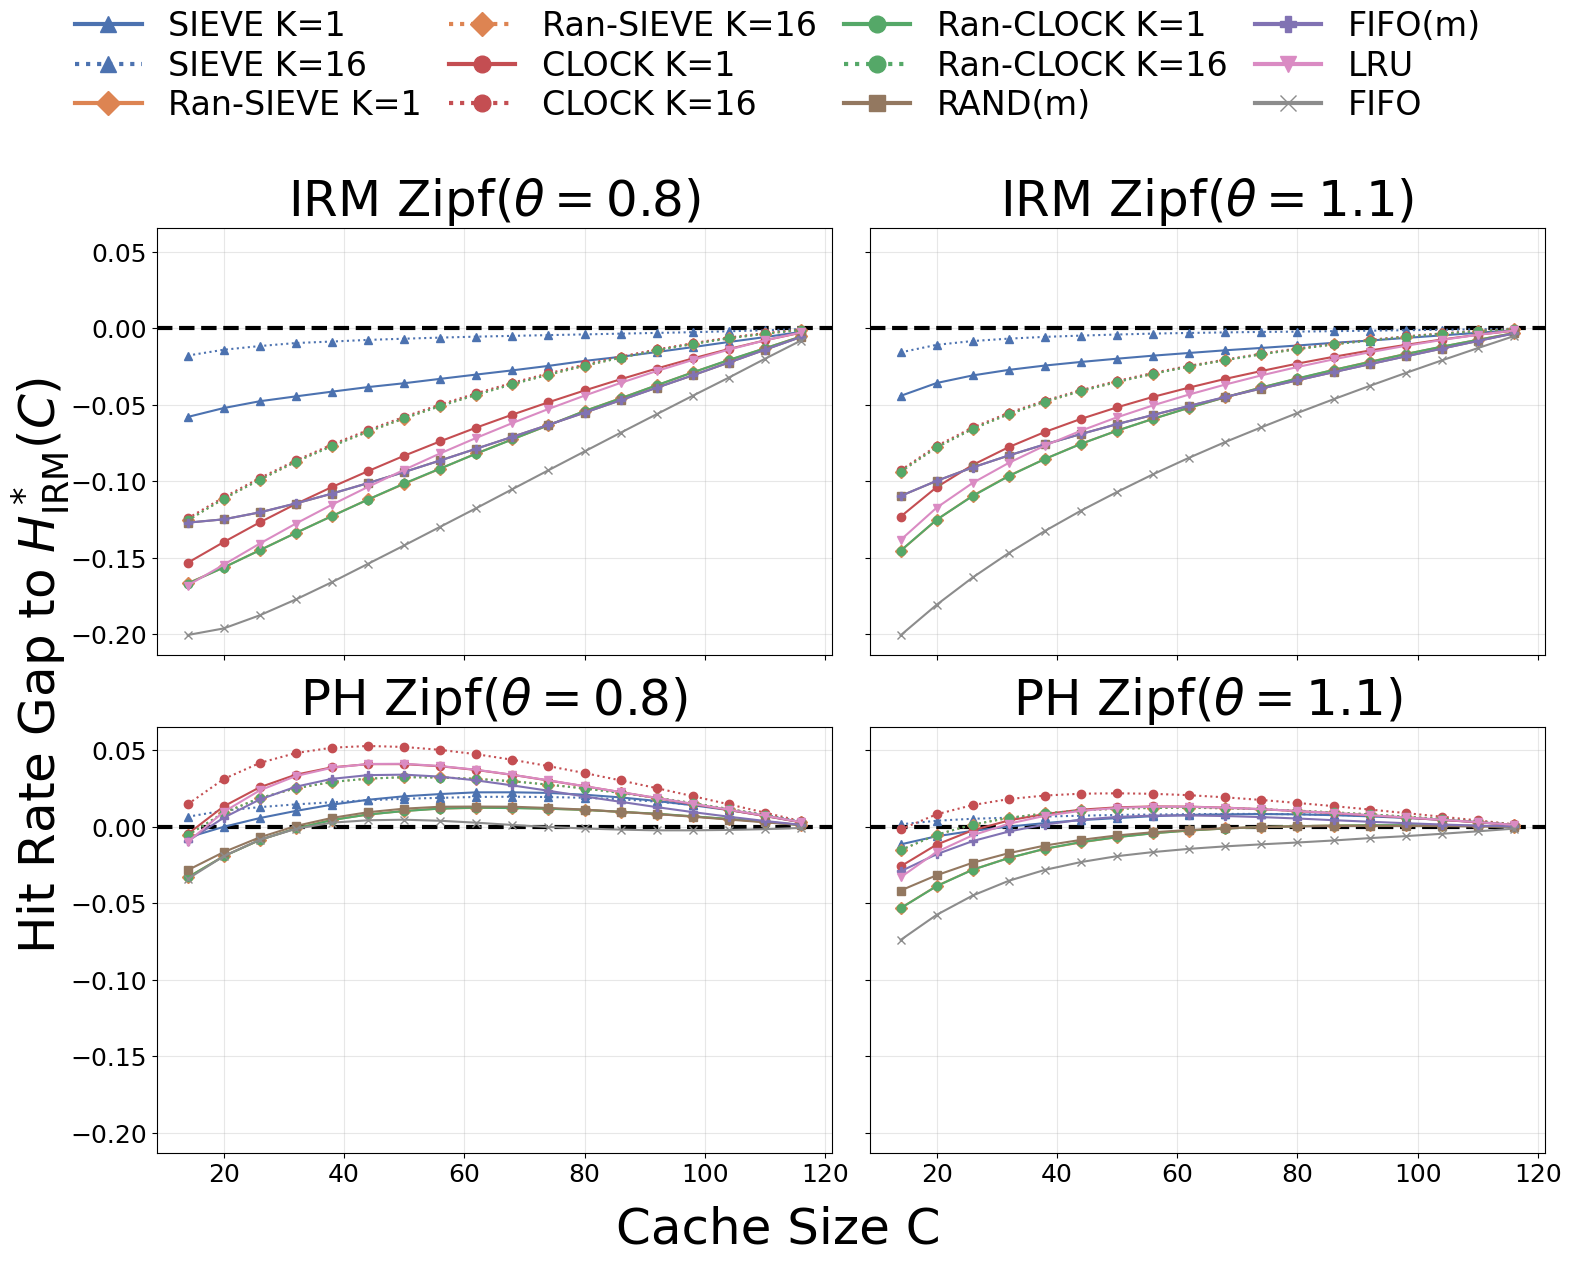

In [147]:
# Combined plot with shared legend above the plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
(ax_irm08_s, ax_irm11_s), (ax_ph08_s, ax_ph11_s) = axes

order_labels = [
    'SIEVE K=1',
    'SIEVE K=16',
    'Ran-SIEVE K=1',
    'Ran-SIEVE K=16',
    'CLOCK K=1',
    'CLOCK K=16',
    'Ran-CLOCK K=1',
    'Ran-CLOCK K=16',
    'RAND(m)',
    'FIFO(m)',
    'LRU',
    'FIFO',
]

lookup_irm_08 = {label: (color, marker, linestyle, c_vals) for label, color, marker, linestyle, c_vals in entries_irm_08}
lookup_irm_11 = {label: (color, marker, linestyle, c_vals) for label, color, marker, linestyle, c_vals in entries_irm_11}
lookup_ph_08 = {label: (color, marker, linestyle, c_vals) for label, color, marker, linestyle, c_vals in entries_ph_08}
lookup_ph_11 = {label: (color, marker, linestyle, c_vals) for label, color, marker, linestyle, c_vals in entries_ph_11}

for ax, title in [
    (ax_ph08_s, 'PH Zipf($\\theta = 0.8$)'),
    (ax_ph11_s, 'PH Zipf($\\theta = 1.1$)'),
    (ax_irm08_s, 'IRM Zipf($\\theta = 0.8$)'),
    (ax_irm11_s, 'IRM Zipf($\\theta = 1.1$)'),
]:
    ax.tick_params(axis='both', labelsize=18)
    ax.axhline(0, color='black', linestyle='--', linewidth=3)
    ax.set_title(title, fontsize=36)
    ax.grid(True)

handles_map = {}

for label in order_labels:
    if label in lookup_irm_08:
        color, marker, linestyle, c_vals = lookup_irm_08[label]
        abs_dist = dist_irm_08[label]
        (line,) = ax_irm08_s.plot(c_vals[2:], abs_dist[2:], marker=marker, label=label, color=color, linestyle=linestyle, linewidth=1.5)
        handles_map.setdefault(label, line)
    if label in lookup_irm_11:
        color, marker, linestyle, c_vals = lookup_irm_11[label]
        abs_dist = dist_irm_11[label]
        ax_irm11_s.plot(c_vals[2:], abs_dist[2:], marker=marker, label=label, color=color, linestyle=linestyle, linewidth=1.5)
    if label in lookup_ph_08:
        color, marker, linestyle, c_vals = lookup_ph_08[label]
        abs_dist = dist_ph_08[label]
        (line_ph08,) = ax_ph08_s.plot(c_vals[2:], abs_dist[2:], marker=marker, label=label, color=color, linestyle=linestyle, linewidth=1.5)
        handles_map.setdefault(label, line_ph08)
    if label in lookup_ph_11:
        color, marker, linestyle, c_vals = lookup_ph_11[label]
        abs_dist = dist_ph_11[label]
        (line_ph11,) = ax_ph11_s.plot(c_vals[2:], abs_dist[2:], marker=marker, label=label, color=color, linestyle=linestyle, linewidth=1.5)
        handles_map.setdefault(label, line_ph11)

ax_irm08_s.grid(True, alpha=0.3)
ax_irm11_s.grid(True, alpha=0.3)
ax_ph08_s.grid(True, alpha=0.3)
ax_ph11_s.grid(True, alpha=0.3)

fig.supxlabel('Cache Size C', fontsize=36)
fig.supylabel('Hit Rate Gap to $H^*_{\mathrm{IRM}}(C)$', fontsize=36)

handles = [handles_map[label] for label in order_labels if label in handles_map]
leg = fig.legend(handles, order_labels, loc='upper center', bbox_to_anchor=(0.5, 1.06), frameon=False, borderpad=0.0, labelspacing=0.2, handlelength=2.0, ncol=4, columnspacing=0.8, fontsize=24)
for line in leg.get_lines():
    line.set_linewidth(3)
    line.set_markersize(12)

fig.tight_layout(rect=[0, 0, 1, 0.92])
fig.savefig('mrcs_synths.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [ ]:
w44_c_s1, w44_hr_s1, w44_c_s16, w44_hr_s16, w44_c_rs1, w44_hr_rs1, w44_c_rs16, w44_hr_rs16, w44_c_rc1, w44_hr_rc1, w44_c_rc16, w44_hr_rc16, w44_c_cc1, w44_hr_cc1, w44_c_cc16, w44_hr_cc16, w44_c_fm, w44_hr_fm, w44_c_rm, w44_hr_rm, w44_c_l, w44_hr_l, w44_c_f, w44_hr_f = np.load('data/w44_mrcs.npz', allow_pickle=True).values()

In [ ]:
w11_c_s1, w11_hr_s1, w11_c_s16, w11_hr_s16, w11_c_rs1, w11_hr_rs1, w11_c_rs16, w11_hr_rs16, w11_c_rc1, w11_hr_rc1, w11_c_rc16, w11_hr_rc16, w11_c_cc1, w11_hr_cc1, w11_c_cc16, w11_hr_cc16, w11_c_fm, w11_hr_fm, w11_c_rm, w11_hr_rm, w11_c_l, w11_hr_l, w11_c_f, w11_hr_f = np.load('data/w11_mrcs.npz', allow_pickle=True).values()

In [ ]:
v28_c_s1, v28_hr_s1, v28_c_s16, v28_hr_s16, v28_c_rs1, v28_hr_rs1, v28_c_rs16, v28_hr_rs16, v28_c_rc1, v28_hr_rc1, v28_c_rc16, v28_hr_rc16, v28_c_cc1, v28_hr_cc1, v28_c_cc16, v28_hr_cc16, v28_c_fm, v28_hr_fm, v28_c_rm, v28_hr_rm, v28_c_l, v28_hr_l, v28_c_f, v28_hr_f = np.load('data/mrcs_v28.npz', allow_pickle=True).values()

In [ ]:
v766_c_s1, v766_hr_s1, v766_c_s16, v766_hr_s16, v766_c_rs1, v766_hr_rs1, v766_c_rs16, v766_hr_rs16, v766_c_rc1, v766_hr_rc1, v766_c_rc16, v766_hr_rc16, v766_c_cc1, v766_hr_cc1, v766_c_cc16, v766_hr_cc16, v766_c_fm, v766_hr_fm, v766_c_rm, v766_hr_rm, v766_c_l, v766_hr_l, v766_c_f, v766_hr_f = np.load('data/mrcs_v766.npz', allow_pickle=True).values()

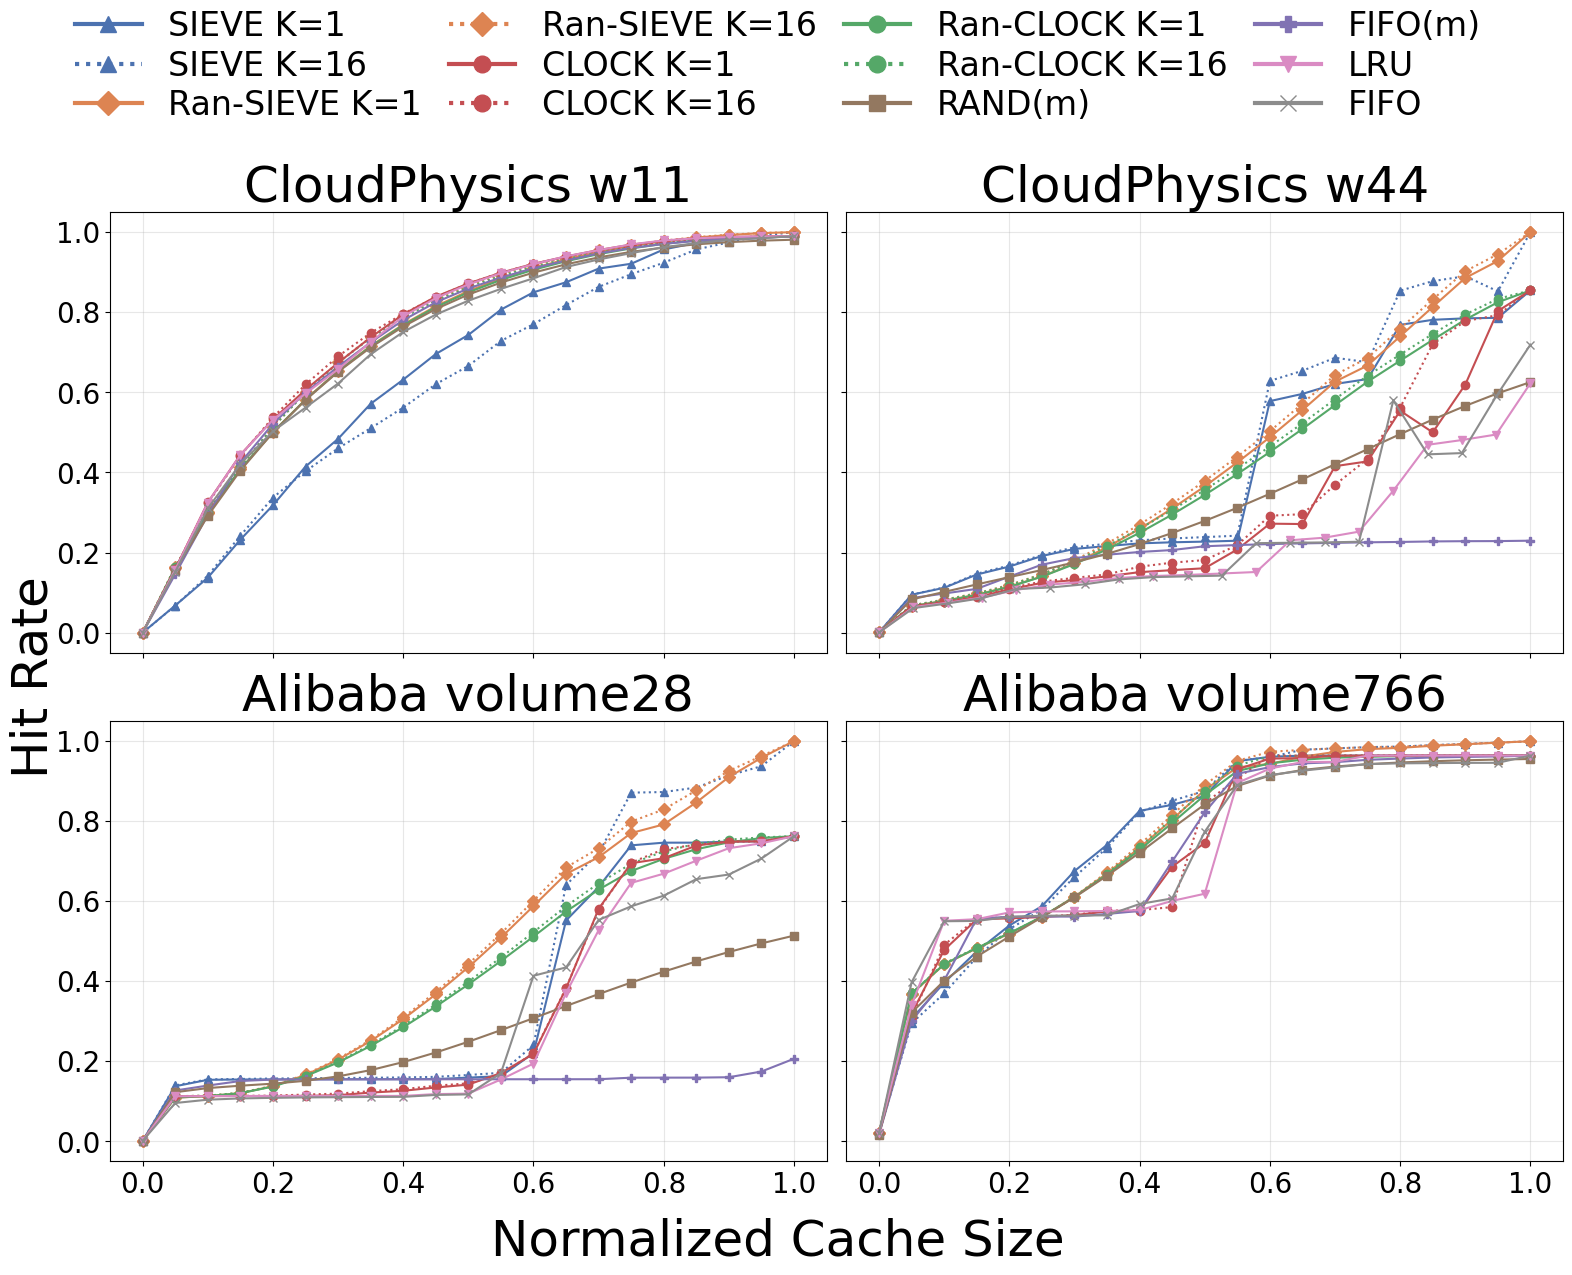

In [146]:

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True, sharey=True)
(ax_w11, ax_w44), (ax_v28, ax_v766) = axes

order_labels = [
    'SIEVE K=1',
    'SIEVE K=16',
    'Ran-SIEVE K=1',
    'Ran-SIEVE K=16',
    'CLOCK K=1',
    'CLOCK K=16',
    'Ran-CLOCK K=1',
    'Ran-CLOCK K=16',
    'RAND(m)',
    'FIFO(m)',
    'LRU',
    'FIFO',
]

style_map = base_styles

def norm_x(xs):
    xs_arr = np.asarray(xs, dtype=float)
    xmax = xs_arr.max()
    return xs_arr / xmax if xmax != 0 else xs_arr

data_sets = [
    (ax_w11, 'CloudPhysics w11', [
        ('SIEVE K=1', w11_c_s1, w11_hr_s1),
        ('SIEVE K=16', w11_c_s16, w11_hr_s16),
        ('Ran-SIEVE K=1', w11_c_rs1, w11_hr_rs1),
        ('Ran-SIEVE K=16', w11_c_rs16, w11_hr_rs16),
        ('Ran-CLOCK K=1', w11_c_rc1, w11_hr_rc1),
        ('Ran-CLOCK K=16', w11_c_rc16, w11_hr_rc16),
        ('CLOCK K=1', w11_c_cc1, w11_hr_cc1),
        ('CLOCK K=16', w11_c_cc16, w11_hr_cc16),
        ('FIFO(m)', w11_c_fm, w11_hr_fm),
        ('RAND(m)', w11_c_rm, w11_hr_rm),
        ('LRU', w11_c_l, w11_hr_l),
        ('FIFO', w11_c_f, w11_hr_f),
    ]),
    (ax_w44, 'CloudPhysics w44', [
        ('SIEVE K=1', w44_c_s1, w44_hr_s1),
        ('SIEVE K=16', w44_c_s16, w44_hr_s16),
        ('Ran-SIEVE K=1', w44_c_rs1, w44_hr_rs1),
        ('Ran-SIEVE K=16', w44_c_rs16, w44_hr_rs16),
        ('Ran-CLOCK K=1', w44_c_rc1, w44_hr_rc1),
        ('Ran-CLOCK K=16', w44_c_rc16, w44_hr_rc16),
        ('CLOCK K=1', w44_c_cc1, w44_hr_cc1),
        ('CLOCK K=16', w44_c_cc16, w44_hr_cc16),
        ('FIFO(m)', w44_c_fm, w44_hr_fm),
        ('RAND(m)', w44_c_rm, w44_hr_rm),
        ('LRU', w44_c_l, w44_hr_l),
        ('FIFO', w44_c_f, w44_hr_f),
    ]),
    (ax_v28, 'Alibaba volume28', [
        ('SIEVE K=1', v28_c_s1, v28_hr_s1),
        ('SIEVE K=16', v28_c_s16, v28_hr_s16),
        ('Ran-SIEVE K=1', v28_c_rs1, v28_hr_rs1),
        ('Ran-SIEVE K=16', v28_c_rs16, v28_hr_rs16),
        ('Ran-CLOCK K=1', v28_c_rc1, v28_hr_rc1),
        ('Ran-CLOCK K=16', v28_c_rc16, v28_hr_rc16),
        ('CLOCK K=1', v28_c_cc1, v28_hr_cc1),
        ('CLOCK K=16', v28_c_cc16, v28_hr_cc16),
        ('FIFO(m)', v28_c_fm, v28_hr_fm),
        ('RAND(m)', v28_c_rm, v28_hr_rm),
        ('LRU', v28_c_l, v28_hr_l),
        ('FIFO', v28_c_f, v28_hr_f),
    ]),
    (ax_v766, 'Alibaba volume766', [
        ('SIEVE K=1', v766_c_s1, v766_hr_s1),
        ('SIEVE K=16', v766_c_s16, v766_hr_s16),
        ('Ran-SIEVE K=1', v766_c_rs1, v766_hr_rs1),
        ('Ran-SIEVE K=16', v766_c_rs16, v766_hr_rs16),
        ('Ran-CLOCK K=1', v766_c_rc1, v766_hr_rc1),
        ('Ran-CLOCK K=16', v766_c_rc16, v766_hr_rc16),
        ('CLOCK K=1', v766_c_cc1, v766_hr_cc1),
        ('CLOCK K=16', v766_c_cc16, v766_hr_cc16),
        ('FIFO(m)', v766_c_fm, v766_hr_fm),
        ('RAND(m)', v766_c_rm, v766_hr_rm),
        ('LRU', v766_c_l, v766_hr_l),
        ('FIFO', v766_c_f, v766_hr_f),
    ]),
]

handles_map = {}
for ax, title, series in data_sets:
    ax.tick_params(axis='both', labelsize=20)
    ax.grid(True, alpha=0.3)
    ax.set_title(title, fontsize=36)
    for label, xs, ys in series:
        base = label.split(' K=')[0]
        color, marker = style_map[base]
        linestyle = ':' if 'K=16' in label else '-'
        xs_norm = norm_x(xs)
        ax.plot(xs_norm, ys, marker=marker, label=label, color=color, linestyle=linestyle, linewidth=1.5)
        if label not in handles_map:
            (h,) = ax.plot([], [], marker=marker, color=color, linestyle=linestyle, linewidth=1.5, label=label)
            handles_map[label] = h

fig.supxlabel('Normalized Cache Size', fontsize=36)
fig.supylabel('Hit Rate', fontsize=36)

handles = [handles_map[label] for label in order_labels]
leg = fig.legend(handles, order_labels, loc='upper center', bbox_to_anchor=(0.5, 1.07), frameon=False, borderpad=0.0, labelspacing=0.2, handlelength=2.0, ncol=4, columnspacing=0.8, fontsize=24)
for line in leg.get_lines():
    line.set_linewidth(3)
    line.set_markersize(12)

fig.tight_layout(rect=[0, 0, 1, 0.94])
fig.savefig('mrcs_real.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [156]:
avgs_w11 = [(name, _, np.mean(hr)) for name, _, hr in data_sets[0][2]]
avgs_w11.sort(key=lambda x: x[2], reverse=True)
avgs_w44 = [(name, _, np.mean(hr)) for name, _, hr in data_sets[1][2]]
avgs_w44.sort(key=lambda x: x[2], reverse=True)
avgs_v28 = [(name, _, np.mean(hr)) for name, _, hr in data_sets[2][2]]
avgs_v28.sort(key=lambda x: x[2], reverse=True)
avgs_v766 = [(name, _, np.mean(hr)) for name, _, hr in data_sets[3][2]]
avgs_v766.sort(key=lambda x: x[2], reverse=True)

print("Average Hit Rates:")
for name, _, avg in avgs_w11:
    print(f"w11 {name}: {avg:.6f}")
print()
for name, _, avg in avgs_w44:
    print(f"w44 {name}: {avg:.6f}")
print()
for name, _, avg in avgs_v28:
    print(f"v28 {name}: {avg:.6f}") 
print()
for name, _, avg in avgs_v766:
    print(f"v766 {name}: {avg:.6f}")

Average Hit Rates:
w11 CLOCK K=16: 0.743730
w11 CLOCK K=1: 0.742469
w11 LRU: 0.740031
w11 Ran-SIEVE K=16: 0.738929
w11 Ran-CLOCK K=16: 0.735301
w11 FIFO(m): 0.732175
w11 Ran-SIEVE K=1: 0.731012
w11 Ran-CLOCK K=1: 0.727485
w11 RAND(m): 0.721683
w11 FIFO: 0.717234
w11 SIEVE K=1: 0.644792
w11 SIEVE K=16: 0.615686

w44 SIEVE K=16: 0.438814
w44 Ran-SIEVE K=16: 0.436661
w44 Ran-SIEVE K=1: 0.425985
w44 SIEVE K=1: 0.401969
w44 Ran-CLOCK K=16: 0.398669
w44 Ran-CLOCK K=1: 0.389595
w44 CLOCK K=16: 0.314025
w44 RAND(m): 0.307528
w44 CLOCK K=1: 0.291756
w44 FIFO: 0.240018
w44 LRU: 0.222171
w44 FIFO(m): 0.183867

v28 Ran-SIEVE K=16: 0.483589
v28 Ran-SIEVE K=1: 0.473707
v28 SIEVE K=16: 0.419414
v28 Ran-CLOCK K=16: 0.417028
v28 Ran-CLOCK K=1: 0.410626
v28 SIEVE K=1: 0.361344
v28 CLOCK K=16: 0.333133
v28 CLOCK K=1: 0.330930
v28 FIFO: 0.316414
v28 LRU: 0.315947
v28 RAND(m): 0.273028
v28 FIFO(m): 0.149186

v766 SIEVE K=16: 0.761866
v766 Ran-SIEVE K=16: 0.758905
v766 SIEVE K=1: 0.755786
v766 Ran-SIEVE K=1

/tmp/ipykernel_2450714/3398955010.py:35: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_2450714/3398955010.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('freqs_irds_real.pdf', bbox_inches='tight', format='pdf')
/home/yirongwn/miniconda3/envs/tracegen/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


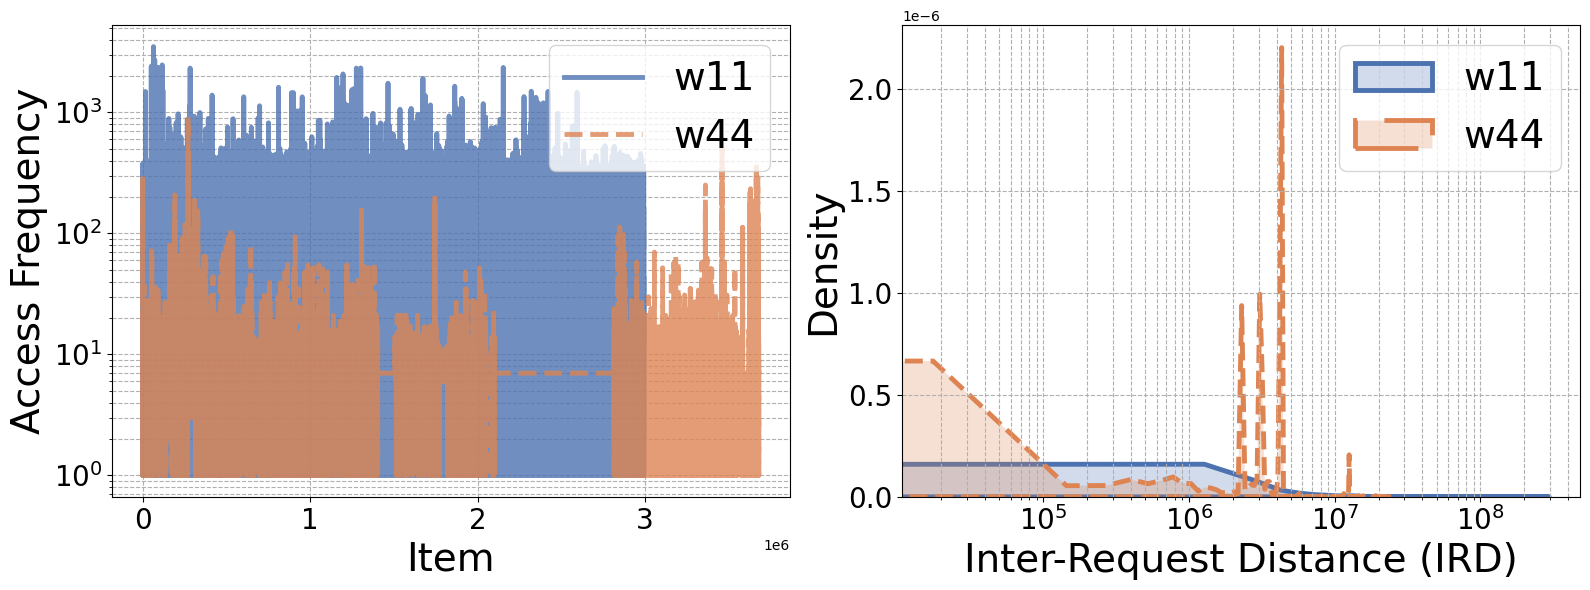

In [149]:
# what happens to w11?

u1, c1 = np.unique(w11, return_counts=True)
u2, c2 = np.unique(w44, return_counts=True)

iads1 = tg.iad(w11)
iads1 = iads1[iads1 > 0]
iads2 = tg.iad(w44)
iads2 = iads2[iads2 > 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Access frequency
ax1.semilogy(u1, c1, label='w11', lw=3.5, color=palette[0], alpha=0.8)
ax1.semilogy(u2, c2, label='w44', lw=3.5, color=palette[1], alpha=0.8, linestyle='--')
ax1.tick_params(axis='both', labelsize=20)
ax1.set_xlabel('Item', fontsize=28)
ax1.set_ylabel('Access Frequency', fontsize=28)
ax1.legend(fontsize=28)
ax1.grid(True, which="both", ls="--")

# IRD KDE
sns.kdeplot(iads1, bw_adjust=0.5, label='w11', fill=True, ax=ax2, color=palette[0], common_norm=False, linewidth=3.5)
sns.kdeplot(iads2, bw_adjust=0.5, label='w44', fill=True, ax=ax2, color=palette[1], common_norm=False, linewidth=3.5, linestyle='--')
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.xaxis.get_major_formatter().set_scientific(True)
ax2.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax2.tick_params(axis='both', labelsize=20)
ax2.set_xscale('log')
ax2.set_xlabel('Inter-Request Distance (IRD)', fontsize=28)
ax2.set_ylabel('Density', fontsize=28)
ax2.legend(fontsize=28)
ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.savefig('freqs_irds_real.pdf', bbox_inches='tight', format='pdf')
plt.show()

